In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as sg
import shapely.affinity as T
import warnings
warnings.filterwarnings("ignore")

In [2]:
ngreen = 1.3642
nred = 1.3590
n_air=1
#----------------------------------------------------------------------------------------------------------------------
class Line:
    
    def __init__(self, p1, p2):
        self.p1=tuple(p1)
        self.p2=tuple(p2)
        self.x1=p1[0]
        self.y1=p1[1]
        self.x2=p2[0]
        self.y2=p2[1]
        self.x1_=None
        self.x2_=None
        self.y1_=None
        self.y2_=None
        self.p1_=(self.x1_,self.y1_)
        self.p2_=(self.x2_,self.y2_)
        self.m=None
        self.b=None
        
    
    def coefficients(self):  
        
        try:
            self.m=(self.y2-self.y1)/(self.x2-self.x1)
            self.b=self.y2-self.m*self.x2
            
        except ZeroDivisionError:
            self.m=np.inf
            self.b=self.x1
            
    
    def line(self,xi=None,xf=None):
        self.coefficients()
        
        if xi is None and xf is None:
            self.x1_ = self.x1
            self.x2_ = self.x2
            self.y1_ = self.y1
            self.y2_ = self.y2
            
        else:
            
            if xi is None:
                self.x1_=self.x1
                self.x2_=xf
                self.y1_=self.y1
                self.y2_=self.m*xf+self.b
                
            elif xf is None:
                self.x1_=xi
                self.x2_=self.x2
                self.y1_=self.m*xi+self.b
                self.y2_=self.y2
                
            else:
                self.x1_=xi
                self.x2_=xf
                self.y1_=self.m*xi+self.b
                self.y2_=self.m*xf+self.b
                
        return sg.LineString([[self.x1_,self.y1_],[self.x2_,self.y2_]])
    
    def coordinates(self,xi=None,xf=None):
        self.coefficients()
        
        if xi is None and xf is None:
            self.x1_ = self.x1
            self.x2_ = self.x2
            self.y1_ = self.y1
            self.y2_ = self.y2
            
        else:
            
            if xi is None:
                self.x1_=self.x1
                self.x2_=xf
                self.y1_=self.y1
                self.y2_=self.m*xf+self.b
                
            elif xf is None:
                self.x1_=xi
                self.x2_=self.x2
                self.y1_=self.m*xi+self.b
                self.y2_=self.y2
                
            else:
                self.x1_=xi
                self.x2_=xf
                self.y1_=self.m*xi+self.b
                self.y2_=self.m*xf+self.b
            
        return np.array([[self.x1_,self.x2_],[self.y1_,self.y2_]])

#-----------------------------------------------------------------------------------------------------------------------   
class Polygon(Line):
    def __init__(self,v1,v2,v3):
        self.vertex1=v1
        self.vertex2=v2
        self.vertex3=v3
    
    def prism(self):
        return sg.Polygon([self.vertex1,self.vertex2,self.vertex3])
    
    def exterior(self):
        return sg.Polygon([self.vertex1,self.vertex2,self.vertex3]).exterior
    
    def linesT(self):
        l=sg.Polygon([self.vertex1,self.vertex2,self.vertex3]).exterior.coords[:]
        u=[]
        for i in range(3):
            u.append((l[i],l[i+1]))
        return u
    
    def linesExterior(self):
        return sg.LineString(self.exterior().coords[:])
    
    def coordinates(self):
        line=sg.LineString(self.prism().exterior.coords[:])
        return np.array([[line.coords[i][0] for i in range(4)],[line.coords[p][1] for p in range(4)]])
    
#-----------------------------------------------------------------------------------------------------------------------     

def coeff(polygon):#calculates the angular and linear coefficients of the lines that compose the polygon
    p=polygon.linesT()
    u=[]
    for i in range(len(p)):
        a=Line(p[i][0],p[i][1])
        a.coefficients()
        u.append([a.m,a.b])
    return u
        
def polyline(polygon):#Create lines objects from the polygon bounds
    u=[]
    for i in range(len(polygon.prism().exterior.coords[:])-1):
        u.append(sg.LineString([polygon.prism().exterior.coords[i],polygon.prism().exterior.coords[i+1]]))
    return u


def thetaP(l1,cl2):#gives us the angle between a line and another line, we need the angular coeff. at the second entry
    l1.coefficients()#the first entry is a regular line object
    l1m=l1.m
    l2m=cl2
    if (l1m==np.inf) or (l2m==np.inf):
        if l1m==np.inf:
            theta=np.pi/2-np.arctan(l2m)
        else:
            theta=np.pi/2-np.arctan(l1m)
    elif(l1m*l2m==-1):
        theta=np.pi/2
    else:
        theta=np.arctan((l1m-l2m)/(1+l1m*l2m))
    return theta

def thetaL(l1,l2):#calculate the angle between two arbitrary lines, both entries are lines objects
    l1.coefficients()
    l2.coefficients()
    if (l1.m==np.inf) or (l2.m==np.inf):
        if l1.m==np.inf:
            theta=np.pi/2-np.arctan(l2.m)
        else:
            theta=np.pi/2-np.arctan(l1.m)
    elif(l1.m*l2.m==-1):
        theta=np.pi/2
    else:
        theta=np.arctan((l1.m-l2.m)/(1+l1.m*l2.m))
    return theta
    
#both functions below gives the exit angle after aplying snell's law
#first entry is a regular line, second entry is a line or the correspondent angular coefficient
def s1(theta,n_medium):
    return (np.arcsin(np.sin(theta)*n_medium/n_air))*180/np.pi

def s2(theta,n_medium):
    return (np.arcsin(np.sin(theta)*n_air/n_medium))*180/np.pi

#initiate the first intersection, this kickstarts the algorithm
def start(line,polygon):
    points1=line.line().intersection(polygon.linesExterior())
    return points1


In [51]:
#calculates all the possibilities for the light ray passing through the prism
#returns the intersection points and line objects for plotting
def main(line,p,n_medium):
    if line.line().intersects(p.linesExterior())==True:
        if str(type(line.line().intersection(p.linesExterior())))=="<class 'shapely.geometry.point.Point'>":
            i1=start(line,p)
        
        else:
            i1=start(line,p)[0]
    else:
        raise Exception('Should intercept')
            
        
    n1 = T.rotate(polyline(p)[2],90,i1.coords[0])
    normal1 = Line(n1.coords[0],n1.coords[1])
    
    l1 = T.rotate(n1,-s2(thetaL(normal1,line),n_medium),i1.coords[0])
    l1_ = Line(l1.coords[0],l1.coords[1])
    
    if Line(l1.coords[0],l1.coords[1]).line(xf=-25,xi=-15).intersects(polyline(p)[0])==True:
        i2 = Line(l1.coords[0],l1.coords[1]).line(xf=-25,xi=-15).intersection(polyline(p)[0])
        
        n2 = T.rotate(polyline(p)[0],90,i2.coords[0])
        normal2 = Line(n2.coords[0],n2.coords[1])
        
        l2 = T.rotate(n2,s1(thetaL(normal2,l1_),n_medium),i2.coords[0])
        l2_ = Line(l2.coords[0],l2.coords[1])
        
        l4=T.rotate(n2,-s1(thetaL(normal2,l1_),n_medium),i2.coords[0])
        l4_ = Line(l4.coords[0],l4.coords[1])
        
        if Line(l2.coords[0],l2.coords[1]).line(xf=-25,xi=-15).intersects(polyline(p)[1])==True:
            i3 = Line(l2.coords[0],l2.coords[1]).line(xf=-25,xi=-15).intersection(polyline(p)[1])
            
            n3 = T.rotate(polyline(p)[1],-90,i3.coords[0])
            normal3 = Line(n3.coords[0],n3.coords[1])
            
            l3 = T.rotate(n3,-s1(thetaL(normal3,l2_),n_medium),i3.coords[0])
            l3_ = Line(l3.coords[0],l3.coords[1])
        
        
        
    elif Line(l1.coords[0],l1.coords[1]).line(xf=-25,xi=-15).intersects(polyline(p)[1])==True:
        n1 = T.rotate(polyline(p)[2],90,i1.coords[0])
        normal1 = Line(n1.coords[0],n1.coords[1])
    
        l1 = T.rotate(n1,s2(thetaL(normal1,line),n_medium),i1.coords[0])
        l1_ = Line(l1.coords[0],l1.coords[1])
        
        
        i2 = Line(l1.coords[0],l1.coords[1]).line(xf=-25,xi=-15).intersection(polyline(p)[1])
                
        n2 = T.rotate(polyline(p)[1],90,i2.coords[0])
        normal2 = Line(n2.coords[0],n2.coords[1])
        
        l2 = T.rotate(n2,s1(thetaL(normal2,l1_),n_medium),i2.coords[0])
        l2_ = Line(l2.coords[0],l2.coords[1])
        
        l4=T.rotate(n2,-s1(thetaL(normal2,l1_)-180,n_medium),i2.coords[0])
        l4_ = Line(l4.coords[0],l4.coords[1])
        
        if Line(l2.coords[0],l2.coords[1]).line(xf=-25,xi=-15).intersects(polyline(p)[0])==True:
            i3 = Line(l2.coords[0],l2.coords[1]).line(xf=-25,xi=-15).intersection(polyline(p)[0])
            
            n3 = T.rotate(polyline(p)[1],-90,i3.coords[0])
            normal3 = Line(n3.coords[0],n3.coords[1])
            
            l3 = T.rotate(n3,-s1(thetaL(normal3,l2_),n_medium),i3.coords[0])
            l3_ = Line(l3.coords[0],l3.coords[1])
     
            
        
    return i1,i2,i3,l1_,l2_,l3_,l4_

In [54]:
p1=Line([-26, 12],[-18,-2])
p2=Line([-26,12],[-18,-2])
p=Polygon((-24.3, 0.4),(-16.86, 1.34),(-21.46, 7.43))
s=main(p1,p,nred)
ss=main(p2,p,ngreen)

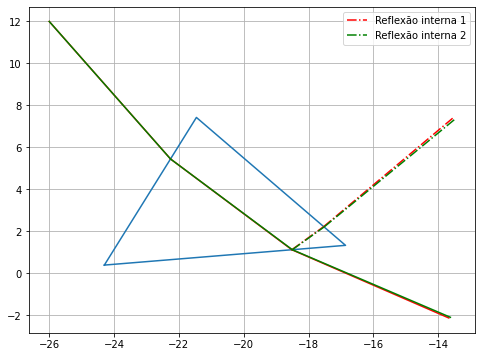

In [55]:
if str(s[5].x1)=='nan' and str(ss[5].x1)=='nan':
    plt.figure(figsize=(8,6))
    plt.plot(p.coordinates()[0],p.coordinates()[1])
    plt.plot([p1.x1,s[0].x],[p1.y1,s[0].y],color='red')
    plt.plot([s[0].x,s[1].x],[s[0].y,s[1].y],color='red')
    plt.plot([s[1].x,s[6].x1],[s[1].y,s[6].y1],color='red')
    
    plt.plot([p2.x1,ss[0].x],[p2.y1,ss[0].y],color='green')
    plt.plot([ss[0].x,ss[1].x],[ss[0].y,ss[1].y],color='green')
    plt.plot([ss[1].x,ss[6].x1],[ss[1].y,ss[6].y1],color='green')
    plt.grid()
    
    
elif str(s[5].x1)=='nan' and str(ss[5].x1)!='nan':
    plt.figure(figsize=(8,6))
    plt.plot(p.coordinates()[0],p.coordinates()[1])
    plt.plot([p2.x1,ss[0].x],[p2.y1,ss[0].y],color='green')
    plt.plot([ss[0].x,ss[1].x],[ss[0].y,ss[1].y],color='green')
    plt.plot([ss[1].x,ss[2].x],[ss[1].y,ss[2].y],linestyle='-.',color='g',label='Reflexão interna')
    plt.plot([ss[2].x,ss[5].x2],[ss[2].y,ss[5].y2],color='g',linestyle='-.')
    plt.plot([ss[1].x,ss[6].x1],[ss[1].y,ss[6].y1],color='green')
    
    plt.plot([p1.x1,s[0].x],[p1.y1,s[0].y],color='red')
    plt.plot([s[0].x,s[1].x],[s[0].y,s[1].y],color='red')
    plt.plot([s[1].x,s[6].x1],[s[1].y,s[6].y1],color='red')
    plt.grid()
    plt.legend()

elif str(s[5].x1)!='nan' and str(ss[5].x1)=='nan':
    plt.figure(figsize=(8,6))
    plt.plot(p.coordinates()[0],p.coordinates()[1])
    plt.plot([p1.x1,s[0].x],[p1.y1,s[0].y],color='red')
    plt.plot([s[0].x,s[1].x],[s[0].y,s[1].y],color='red')
    plt.plot([s[1].x,s[2].x],[s[1].y,s[2].y],linestyle='-.',color='red',label='Reflexão interna')
    plt.plot([s[2].x,s[5].x2],[s[2].y,s[5].y2],color='red',linestyle='-.')
    plt.plot([s[1].x,s[6].x1],[s[1].y,s[6].y1],color='red')
    
    plt.plot([p2.x1,ss[0].x],[p2.y1,ss[0].y],color='green')
    plt.plot([ss[0].x,ss[1].x],[ss[0].y,ss[1].y],color='green')
    plt.plot([ss[1].x,ss[6].x1],[ss[1].y,ss[6].y1],color='green')
    plt.grid()
    plt.legend()
    
elif str(s[5].x1)!='nan' and str(ss[5].x1)!='nan':
    plt.figure(figsize=(8,6))
    plt.plot(p.coordinates()[0],p.coordinates()[1])
    plt.plot([p1.x1,s[0].x],[p1.y1,s[0].y],color='red')
    plt.plot([s[0].x,s[1].x],[s[0].y,s[1].y],color='red')
    plt.plot([s[1].x,s[2].x],[s[1].y,s[2].y],linestyle='-.',color='red',label='Reflexão interna 1')
    plt.plot([s[2].x,s[5].x2],[s[2].y,s[5].y2],color='red',linestyle='-.')
    plt.plot([s[1].x,s[6].x1],[s[1].y,s[6].y1],color='red')
    
    plt.plot([p2.x1,ss[0].x],[p2.y1,ss[0].y],color='green')
    plt.plot([ss[0].x,ss[1].x],[ss[0].y,ss[1].y],color='green')
    plt.plot([ss[1].x,ss[2].x],[ss[1].y,ss[2].y],linestyle='-.',color='g',label='Reflexão interna 2')
    plt.plot([ss[2].x,ss[5].x2],[ss[2].y,ss[5].y2],color='g',linestyle='-.')
    plt.plot([ss[1].x,ss[6].x1],[ss[1].y,ss[6].y1],color='green')
    plt.legend()
    plt.grid()
    
plt.savefig(r'C:\Users\rmarc\Downloads\imagem 5.png', dpi=100, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

# Documentation

## Classes:
Above we have the creation of 2 classes, Line and Polygon, each one with it's respective use.

### 1) Line:
    - Coefficients method: "coefficients(self)"-> calculates angular and linear coefficients of a line. 
    - line method: "line(self,xi=None,xf=None)"-> alongates a line to the position xi or/and xf, if xi or xf is None, maintain the original coordinates.
    - coordinates method: "coordinates(self,xi=None,xf=None)"-> gives de xy coordinates of the original line, or the line with new coordinates, provide with give the xi or/and xf coordinates (useful for plotting in matplotlib).
    
### 2) Polygon:
    -prism method: "prism(self)"-> Returns a closed polygon with the given vertex
    -exterior method: "exterior(self)"-> returns the exterior properties of the polygon
    -linesT method:"linesT(self)"-> returns a list with the exterior points of the closed polygon
    -linesExterior method:"linesExterior(self)"-> returns the set of lines that compose the exterior of the polygon
    -coordinates method:"coordinates(self)"-> returns the xy coordinates of the the exterior points of the polygon